# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Tanh()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Tanh()
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)

#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [8]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients

#         # Record the correct predictions for training data
#         _, predictions = torch.max(pred.data, 1)
#         train_correct += (predictions == y.data).sum()                
#         train_total += predictions.size(0)    

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping
    #train_loss.append(loss.item())
    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

#     loss = criterion(outputs, Variable(test_classes))
#     test_loss.append(loss.data[0])

Epoch 1/200, Iteration 1/25, Loss: 0.0943
Epoch 1/200, Iteration 2/25, Loss: 1.5434
Epoch 1/200, Iteration 3/25, Loss: 2.7836
Epoch 1/200, Iteration 4/25, Loss: 2.0634
Epoch 1/200, Iteration 5/25, Loss: 0.8678
Epoch 1/200, Iteration 6/25, Loss: 0.4569
Epoch 1/200, Iteration 7/25, Loss: 0.5997
Epoch 1/200, Iteration 8/25, Loss: 0.4607
Epoch 1/200, Iteration 9/25, Loss: 0.3402
Epoch 1/200, Iteration 10/25, Loss: 0.5157
Epoch 1/200, Iteration 11/25, Loss: 0.2512
Epoch 1/200, Iteration 12/25, Loss: 0.3820
Epoch 1/200, Iteration 13/25, Loss: 0.4267
Epoch 1/200, Iteration 14/25, Loss: 0.2559
Epoch 1/200, Iteration 15/25, Loss: 0.2290
Epoch 1/200, Iteration 16/25, Loss: 0.1852
Epoch 1/200, Iteration 17/25, Loss: 0.1346
Epoch 1/200, Iteration 18/25, Loss: 0.1170
Epoch 1/200, Iteration 19/25, Loss: 0.1610
Epoch 1/200, Iteration 20/25, Loss: 0.1050
Epoch 1/200, Iteration 21/25, Loss: 0.1734
Epoch 1/200, Iteration 22/25, Loss: 0.0842
Epoch 1/200, Iteration 23/25, Loss: 0.0965
Epoch 1/200, Iterati

Epoch 8/200, Iteration 4/25, Loss: 0.0848
Epoch 8/200, Iteration 5/25, Loss: 0.0827
Epoch 8/200, Iteration 6/25, Loss: 0.0846
Epoch 8/200, Iteration 7/25, Loss: 0.0656
Epoch 8/200, Iteration 8/25, Loss: 0.0805
Epoch 8/200, Iteration 9/25, Loss: 0.0788
Epoch 8/200, Iteration 10/25, Loss: 0.0675
Epoch 8/200, Iteration 11/25, Loss: 0.0402
Epoch 8/200, Iteration 12/25, Loss: 0.0505
Epoch 8/200, Iteration 13/25, Loss: 0.0695
Epoch 8/200, Iteration 14/25, Loss: 0.0369
Epoch 8/200, Iteration 15/25, Loss: 0.0363
Epoch 8/200, Iteration 16/25, Loss: 0.0488
Epoch 8/200, Iteration 17/25, Loss: 0.0673
Epoch 8/200, Iteration 18/25, Loss: 0.0332
Epoch 8/200, Iteration 19/25, Loss: 0.0521
Epoch 8/200, Iteration 20/25, Loss: 0.0512
Epoch 8/200, Iteration 21/25, Loss: 0.0514
Epoch 8/200, Iteration 22/25, Loss: 0.0678
Epoch 8/200, Iteration 23/25, Loss: 0.0443
Epoch 8/200, Iteration 24/25, Loss: 0.0861
Epoch 8/200, Iteration 25/25, Loss: 0.0708
Train Error: 
 Accuracy: 49.12%, Avg loss: 0.049395, MRE: 2.

Epoch 15/200, Iteration 24/25, Loss: 0.0331
Epoch 15/200, Iteration 25/25, Loss: 0.0333
Train Error: 
 Accuracy: 70.62%, Avg loss: 0.033638, MRE: 1.656886 

Test Error: 
 Accuracy: 70.5%, Avg loss: 0.034146, MRE: 6.673153 

Epoch 16/200, Iteration 1/25, Loss: 0.0380
Epoch 16/200, Iteration 2/25, Loss: 0.0429
Epoch 16/200, Iteration 3/25, Loss: 0.0410
Epoch 16/200, Iteration 4/25, Loss: 0.0347
Epoch 16/200, Iteration 5/25, Loss: 0.0348
Epoch 16/200, Iteration 6/25, Loss: 0.0323
Epoch 16/200, Iteration 7/25, Loss: 0.0199
Epoch 16/200, Iteration 8/25, Loss: 0.0315
Epoch 16/200, Iteration 9/25, Loss: 0.0502
Epoch 16/200, Iteration 10/25, Loss: 0.0715
Epoch 16/200, Iteration 11/25, Loss: 0.0297
Epoch 16/200, Iteration 12/25, Loss: 0.0787
Epoch 16/200, Iteration 13/25, Loss: 0.0643
Epoch 16/200, Iteration 14/25, Loss: 0.0368
Epoch 16/200, Iteration 15/25, Loss: 0.0779
Epoch 16/200, Iteration 16/25, Loss: 0.0281
Epoch 16/200, Iteration 17/25, Loss: 0.0376
Epoch 16/200, Iteration 18/25, Loss: 

Test Error: 
 Accuracy: 44.0%, Avg loss: 0.048464, MRE: 3.462789 

Epoch 23/200, Iteration 1/25, Loss: 0.0454
Epoch 23/200, Iteration 2/25, Loss: 0.1132
Epoch 23/200, Iteration 3/25, Loss: 0.0862
Epoch 23/200, Iteration 4/25, Loss: 0.0825
Epoch 23/200, Iteration 5/25, Loss: 0.1381
Epoch 23/200, Iteration 6/25, Loss: 0.0373
Epoch 23/200, Iteration 7/25, Loss: 0.1208
Epoch 23/200, Iteration 8/25, Loss: 0.1098
Epoch 23/200, Iteration 9/25, Loss: 0.0571
Epoch 23/200, Iteration 10/25, Loss: 0.0690
Epoch 23/200, Iteration 11/25, Loss: 0.1011
Epoch 23/200, Iteration 12/25, Loss: 0.0645
Epoch 23/200, Iteration 13/25, Loss: 0.0319
Epoch 23/200, Iteration 14/25, Loss: 0.0969
Epoch 23/200, Iteration 15/25, Loss: 0.0677
Epoch 23/200, Iteration 16/25, Loss: 0.1172
Epoch 23/200, Iteration 17/25, Loss: 0.0474
Epoch 23/200, Iteration 18/25, Loss: 0.0431
Epoch 23/200, Iteration 19/25, Loss: 0.0816
Epoch 23/200, Iteration 20/25, Loss: 0.1012
Epoch 23/200, Iteration 21/25, Loss: 0.1044
Epoch 23/200, Iter

Train Error: 
 Accuracy: 79.62%, Avg loss: 0.040349, MRE: 2.092742 

Test Error: 
 Accuracy: 78.0%, Avg loss: 0.040691, MRE: 4.741995 

Epoch 30/200, Iteration 1/25, Loss: 0.0447
Epoch 30/200, Iteration 2/25, Loss: 0.0408
Epoch 30/200, Iteration 3/25, Loss: 0.0465
Epoch 30/200, Iteration 4/25, Loss: 0.0390
Epoch 30/200, Iteration 5/25, Loss: 0.0417
Epoch 30/200, Iteration 6/25, Loss: 0.0403
Epoch 30/200, Iteration 7/25, Loss: 0.0296
Epoch 30/200, Iteration 8/25, Loss: 0.0394
Epoch 30/200, Iteration 9/25, Loss: 0.0540
Epoch 30/200, Iteration 10/25, Loss: 0.0420
Epoch 30/200, Iteration 11/25, Loss: 0.0604
Epoch 30/200, Iteration 12/25, Loss: 0.0369
Epoch 30/200, Iteration 13/25, Loss: 0.0494
Epoch 30/200, Iteration 14/25, Loss: 0.0574
Epoch 30/200, Iteration 15/25, Loss: 0.0305
Epoch 30/200, Iteration 16/25, Loss: 0.0465
Epoch 30/200, Iteration 17/25, Loss: 0.0454
Epoch 30/200, Iteration 18/25, Loss: 0.0359
Epoch 30/200, Iteration 19/25, Loss: 0.0641
Epoch 30/200, Iteration 20/25, Loss: 

Epoch 36/200, Iteration 24/25, Loss: 0.0512
Epoch 36/200, Iteration 25/25, Loss: 0.0620
Train Error: 
 Accuracy: 58.63%, Avg loss: 0.050293, MRE: 3.003004 

Test Error: 
 Accuracy: 61.0%, Avg loss: 0.054090, MRE: 6.947512 

Epoch 37/200, Iteration 1/25, Loss: 0.0531
Epoch 37/200, Iteration 2/25, Loss: 0.0305
Epoch 37/200, Iteration 3/25, Loss: 0.0383
Epoch 37/200, Iteration 4/25, Loss: 0.0630
Epoch 37/200, Iteration 5/25, Loss: 0.0610
Epoch 37/200, Iteration 6/25, Loss: 0.0562
Epoch 37/200, Iteration 7/25, Loss: 0.0562
Epoch 37/200, Iteration 8/25, Loss: 0.0386
Epoch 37/200, Iteration 9/25, Loss: 0.0416
Epoch 37/200, Iteration 10/25, Loss: 0.0499
Epoch 37/200, Iteration 11/25, Loss: 0.0504
Epoch 37/200, Iteration 12/25, Loss: 0.0466
Epoch 37/200, Iteration 13/25, Loss: 0.0311
Epoch 37/200, Iteration 14/25, Loss: 0.0494
Epoch 37/200, Iteration 15/25, Loss: 0.0700
Epoch 37/200, Iteration 16/25, Loss: 0.0356
Epoch 37/200, Iteration 17/25, Loss: 0.0469
Epoch 37/200, Iteration 18/25, Loss: 

Train Error: 
 Accuracy: 57.5%, Avg loss: 0.307667, MRE: 14.618318 

Test Error: 
 Accuracy: 60.5%, Avg loss: 0.310033, MRE: 15.559229 

Epoch 44/200, Iteration 1/25, Loss: 0.2810
Epoch 44/200, Iteration 2/25, Loss: 0.3038
Epoch 44/200, Iteration 3/25, Loss: 0.1855
Epoch 44/200, Iteration 4/25, Loss: 0.0612
Epoch 44/200, Iteration 5/25, Loss: 0.1537
Epoch 44/200, Iteration 6/25, Loss: 0.1979
Epoch 44/200, Iteration 7/25, Loss: 0.2241
Epoch 44/200, Iteration 8/25, Loss: 0.1175
Epoch 44/200, Iteration 9/25, Loss: 0.0790
Epoch 44/200, Iteration 10/25, Loss: 0.1171
Epoch 44/200, Iteration 11/25, Loss: 0.0602
Epoch 44/200, Iteration 12/25, Loss: 0.1858
Epoch 44/200, Iteration 13/25, Loss: 0.1147
Epoch 44/200, Iteration 14/25, Loss: 0.1081
Epoch 44/200, Iteration 15/25, Loss: 0.1409
Epoch 44/200, Iteration 16/25, Loss: 0.1103
Epoch 44/200, Iteration 17/25, Loss: 0.2504
Epoch 44/200, Iteration 18/25, Loss: 0.2102
Epoch 44/200, Iteration 19/25, Loss: 0.1728
Epoch 44/200, Iteration 20/25, Loss:

Epoch 51/200, Iteration 6/25, Loss: 0.0920
Epoch 51/200, Iteration 7/25, Loss: 0.0813
Epoch 51/200, Iteration 8/25, Loss: 0.0849
Epoch 51/200, Iteration 9/25, Loss: 0.1042
Epoch 51/200, Iteration 10/25, Loss: 0.0816
Epoch 51/200, Iteration 11/25, Loss: 0.0550
Epoch 51/200, Iteration 12/25, Loss: 0.0412
Epoch 51/200, Iteration 13/25, Loss: 0.0630
Epoch 51/200, Iteration 14/25, Loss: 0.0906
Epoch 51/200, Iteration 15/25, Loss: 0.0941
Epoch 51/200, Iteration 16/25, Loss: 0.0711
Epoch 51/200, Iteration 17/25, Loss: 0.0790
Epoch 51/200, Iteration 18/25, Loss: 0.0408
Epoch 51/200, Iteration 19/25, Loss: 0.0488
Epoch 51/200, Iteration 20/25, Loss: 0.0659
Epoch 51/200, Iteration 21/25, Loss: 0.1536
Epoch 51/200, Iteration 22/25, Loss: 0.1015
Epoch 51/200, Iteration 23/25, Loss: 0.0570
Epoch 51/200, Iteration 24/25, Loss: 0.1593
Epoch 51/200, Iteration 25/25, Loss: 0.1854
Train Error: 
 Accuracy: 27.88%, Avg loss: 0.135967, MRE: 7.167351 

Test Error: 
 Accuracy: 29.0%, Avg loss: 0.139460, MRE:

Train Error: 
 Accuracy: 50.38%, Avg loss: 0.066868, MRE: 3.295627 

Test Error: 
 Accuracy: 47.0%, Avg loss: 0.070043, MRE: 8.947855 

Epoch 58/200, Iteration 1/25, Loss: 0.0417
Epoch 58/200, Iteration 2/25, Loss: 0.0472
Epoch 58/200, Iteration 3/25, Loss: 0.0675
Epoch 58/200, Iteration 4/25, Loss: 0.0672
Epoch 58/200, Iteration 5/25, Loss: 0.0776
Epoch 58/200, Iteration 6/25, Loss: 0.0594
Epoch 58/200, Iteration 7/25, Loss: 0.0839
Epoch 58/200, Iteration 8/25, Loss: 0.0557
Epoch 58/200, Iteration 9/25, Loss: 0.0433
Epoch 58/200, Iteration 10/25, Loss: 0.0614
Epoch 58/200, Iteration 11/25, Loss: 0.0946
Epoch 58/200, Iteration 12/25, Loss: 0.0579
Epoch 58/200, Iteration 13/25, Loss: 0.0729
Epoch 58/200, Iteration 14/25, Loss: 0.1032
Epoch 58/200, Iteration 15/25, Loss: 0.0827
Epoch 58/200, Iteration 16/25, Loss: 0.0814
Epoch 58/200, Iteration 17/25, Loss: 0.1208
Epoch 58/200, Iteration 18/25, Loss: 0.0774
Epoch 58/200, Iteration 19/25, Loss: 0.1289
Epoch 58/200, Iteration 20/25, Loss: 

Epoch 65/200, Iteration 7/25, Loss: 0.0439
Epoch 65/200, Iteration 8/25, Loss: 0.0596
Epoch 65/200, Iteration 9/25, Loss: 0.0816
Epoch 65/200, Iteration 10/25, Loss: 0.1098
Epoch 65/200, Iteration 11/25, Loss: 0.0581
Epoch 65/200, Iteration 12/25, Loss: 0.1022
Epoch 65/200, Iteration 13/25, Loss: 0.1056
Epoch 65/200, Iteration 14/25, Loss: 0.1191
Epoch 65/200, Iteration 15/25, Loss: 0.1152
Epoch 65/200, Iteration 16/25, Loss: 0.0834
Epoch 65/200, Iteration 17/25, Loss: 0.1318
Epoch 65/200, Iteration 18/25, Loss: 0.0965
Epoch 65/200, Iteration 19/25, Loss: 0.0899
Epoch 65/200, Iteration 20/25, Loss: 0.1401
Epoch 65/200, Iteration 21/25, Loss: 0.1114
Epoch 65/200, Iteration 22/25, Loss: 0.0955
Epoch 65/200, Iteration 23/25, Loss: 0.1467
Epoch 65/200, Iteration 24/25, Loss: 0.1857
Epoch 65/200, Iteration 25/25, Loss: 0.1101
Train Error: 
 Accuracy: 66.88%, Avg loss: 0.108611, MRE: 8.752278 

Test Error: 
 Accuracy: 61.0%, Avg loss: 0.100131, MRE: 18.723004 

Epoch 66/200, Iteration 1/25, 

Epoch 72/200, Iteration 8/25, Loss: 0.1263
Epoch 72/200, Iteration 9/25, Loss: 0.0727
Epoch 72/200, Iteration 10/25, Loss: 0.1108
Epoch 72/200, Iteration 11/25, Loss: 0.0790
Epoch 72/200, Iteration 12/25, Loss: 0.0686
Epoch 72/200, Iteration 13/25, Loss: 0.0620
Epoch 72/200, Iteration 14/25, Loss: 0.0879
Epoch 72/200, Iteration 15/25, Loss: 0.0520
Epoch 72/200, Iteration 16/25, Loss: 0.0430
Epoch 72/200, Iteration 17/25, Loss: 0.0792
Epoch 72/200, Iteration 18/25, Loss: 0.0498
Epoch 72/200, Iteration 19/25, Loss: 0.0549
Epoch 72/200, Iteration 20/25, Loss: 0.0817
Epoch 72/200, Iteration 21/25, Loss: 0.0609
Epoch 72/200, Iteration 22/25, Loss: 0.0635
Epoch 72/200, Iteration 23/25, Loss: 0.0594
Epoch 72/200, Iteration 24/25, Loss: 0.0597
Epoch 72/200, Iteration 25/25, Loss: 0.0414
Train Error: 
 Accuracy: 48.25%, Avg loss: 0.078442, MRE: 5.398603 

Test Error: 
 Accuracy: 44.5%, Avg loss: 0.075531, MRE: 21.114048 

Epoch 73/200, Iteration 1/25, Loss: 0.0745
Epoch 73/200, Iteration 2/25, 

Epoch 79/200, Iteration 13/25, Loss: 0.1201
Epoch 79/200, Iteration 14/25, Loss: 0.1407
Epoch 79/200, Iteration 15/25, Loss: 0.0826
Epoch 79/200, Iteration 16/25, Loss: 0.1829
Epoch 79/200, Iteration 17/25, Loss: 0.1128
Epoch 79/200, Iteration 18/25, Loss: 0.2063
Epoch 79/200, Iteration 19/25, Loss: 0.2640
Epoch 79/200, Iteration 20/25, Loss: 0.0521
Epoch 79/200, Iteration 21/25, Loss: 0.2760
Epoch 79/200, Iteration 22/25, Loss: 0.3579
Epoch 79/200, Iteration 23/25, Loss: 0.1763
Epoch 79/200, Iteration 24/25, Loss: 0.2525
Epoch 79/200, Iteration 25/25, Loss: 0.3758
Train Error: 
 Accuracy: 67.12%, Avg loss: 0.246253, MRE: 15.342233 

Test Error: 
 Accuracy: 74.0%, Avg loss: 0.233627, MRE: 37.209170 

Epoch 80/200, Iteration 1/25, Loss: 0.2421
Epoch 80/200, Iteration 2/25, Loss: 0.1429
Epoch 80/200, Iteration 3/25, Loss: 0.2863
Epoch 80/200, Iteration 4/25, Loss: 0.1993
Epoch 80/200, Iteration 5/25, Loss: 0.0836
Epoch 80/200, Iteration 6/25, Loss: 0.2183
Epoch 80/200, Iteration 7/25, Lo

Epoch 87/200, Iteration 2/25, Loss: 0.1598
Epoch 87/200, Iteration 3/25, Loss: 0.0822
Epoch 87/200, Iteration 4/25, Loss: 0.2013
Epoch 87/200, Iteration 5/25, Loss: 0.1979
Epoch 87/200, Iteration 6/25, Loss: 0.0916
Epoch 87/200, Iteration 7/25, Loss: 0.1524
Epoch 87/200, Iteration 8/25, Loss: 0.2049
Epoch 87/200, Iteration 9/25, Loss: 0.0846
Epoch 87/200, Iteration 10/25, Loss: 0.1372
Epoch 87/200, Iteration 11/25, Loss: 0.1372
Epoch 87/200, Iteration 12/25, Loss: 0.0608
Epoch 87/200, Iteration 13/25, Loss: 0.0942
Epoch 87/200, Iteration 14/25, Loss: 0.0982
Epoch 87/200, Iteration 15/25, Loss: 0.0835
Epoch 87/200, Iteration 16/25, Loss: 0.0937
Epoch 87/200, Iteration 17/25, Loss: 0.0477
Epoch 87/200, Iteration 18/25, Loss: 0.0695
Epoch 87/200, Iteration 19/25, Loss: 0.0722
Epoch 87/200, Iteration 20/25, Loss: 0.0803
Epoch 87/200, Iteration 21/25, Loss: 0.0794
Epoch 87/200, Iteration 22/25, Loss: 0.0687
Epoch 87/200, Iteration 23/25, Loss: 0.0610
Epoch 87/200, Iteration 24/25, Loss: 0.0

Epoch 94/200, Iteration 20/25, Loss: 0.0599
Epoch 94/200, Iteration 21/25, Loss: 0.0756
Epoch 94/200, Iteration 22/25, Loss: 0.0519
Epoch 94/200, Iteration 23/25, Loss: 0.0708
Epoch 94/200, Iteration 24/25, Loss: 0.1021
Epoch 94/200, Iteration 25/25, Loss: 0.1079
Train Error: 
 Accuracy: 55.88%, Avg loss: 0.066226, MRE: 4.245683 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.072850, MRE: 16.495093 

Epoch 95/200, Iteration 1/25, Loss: 0.0672
Epoch 95/200, Iteration 2/25, Loss: 0.1353
Epoch 95/200, Iteration 3/25, Loss: 0.0969
Epoch 95/200, Iteration 4/25, Loss: 0.1363
Epoch 95/200, Iteration 5/25, Loss: 0.1684
Epoch 95/200, Iteration 6/25, Loss: 0.0766
Epoch 95/200, Iteration 7/25, Loss: 0.1520
Epoch 95/200, Iteration 8/25, Loss: 0.0678
Epoch 95/200, Iteration 9/25, Loss: 0.1192
Epoch 95/200, Iteration 10/25, Loss: 0.0799
Epoch 95/200, Iteration 11/25, Loss: 0.0866
Epoch 95/200, Iteration 12/25, Loss: 0.0624
Epoch 95/200, Iteration 13/25, Loss: 0.0452
Epoch 95/200, Iteration 14/25, Loss:

Epoch 102/200, Iteration 3/25, Loss: 0.1532
Epoch 102/200, Iteration 4/25, Loss: 0.1376
Epoch 102/200, Iteration 5/25, Loss: 0.1180
Epoch 102/200, Iteration 6/25, Loss: 0.1977
Epoch 102/200, Iteration 7/25, Loss: 0.1517
Epoch 102/200, Iteration 8/25, Loss: 0.0854
Epoch 102/200, Iteration 9/25, Loss: 0.1608
Epoch 102/200, Iteration 10/25, Loss: 0.1845
Epoch 102/200, Iteration 11/25, Loss: 0.0930
Epoch 102/200, Iteration 12/25, Loss: 0.1116
Epoch 102/200, Iteration 13/25, Loss: 0.0660
Epoch 102/200, Iteration 14/25, Loss: 0.0985
Epoch 102/200, Iteration 15/25, Loss: 0.0614
Epoch 102/200, Iteration 16/25, Loss: 0.1009
Epoch 102/200, Iteration 17/25, Loss: 0.0625
Epoch 102/200, Iteration 18/25, Loss: 0.0892
Epoch 102/200, Iteration 19/25, Loss: 0.1053
Epoch 102/200, Iteration 20/25, Loss: 0.0395
Epoch 102/200, Iteration 21/25, Loss: 0.1577
Epoch 102/200, Iteration 22/25, Loss: 0.1867
Epoch 102/200, Iteration 23/25, Loss: 0.1038
Epoch 102/200, Iteration 24/25, Loss: 0.0813
Epoch 102/200, It

Train Error: 
 Accuracy: 94.88%, Avg loss: 0.079970, MRE: 4.814701 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.077491, MRE: 7.411124 

Epoch 109/200, Iteration 1/25, Loss: 0.0967
Epoch 109/200, Iteration 2/25, Loss: 0.0502
Epoch 109/200, Iteration 3/25, Loss: 0.0512
Epoch 109/200, Iteration 4/25, Loss: 0.0832
Epoch 109/200, Iteration 5/25, Loss: 0.0740
Epoch 109/200, Iteration 6/25, Loss: 0.0705
Epoch 109/200, Iteration 7/25, Loss: 0.0613
Epoch 109/200, Iteration 8/25, Loss: 0.0927
Epoch 109/200, Iteration 9/25, Loss: 0.0974
Epoch 109/200, Iteration 10/25, Loss: 0.0920
Epoch 109/200, Iteration 11/25, Loss: 0.0777
Epoch 109/200, Iteration 12/25, Loss: 0.0809
Epoch 109/200, Iteration 13/25, Loss: 0.0487
Epoch 109/200, Iteration 14/25, Loss: 0.0753
Epoch 109/200, Iteration 15/25, Loss: 0.0571
Epoch 109/200, Iteration 16/25, Loss: 0.0507
Epoch 109/200, Iteration 17/25, Loss: 0.0460
Epoch 109/200, Iteration 18/25, Loss: 0.0988
Epoch 109/200, Iteration 19/25, Loss: 0.1069
Epoch 109/200, Ite

Epoch 116/200, Iteration 6/25, Loss: 0.1816
Epoch 116/200, Iteration 7/25, Loss: 0.2618
Epoch 116/200, Iteration 8/25, Loss: 0.1769
Epoch 116/200, Iteration 9/25, Loss: 0.1276
Epoch 116/200, Iteration 10/25, Loss: 0.2157
Epoch 116/200, Iteration 11/25, Loss: 0.2854
Epoch 116/200, Iteration 12/25, Loss: 0.2342
Epoch 116/200, Iteration 13/25, Loss: 0.2326
Epoch 116/200, Iteration 14/25, Loss: 0.1503
Epoch 116/200, Iteration 15/25, Loss: 0.1675
Epoch 116/200, Iteration 16/25, Loss: 0.1421
Epoch 116/200, Iteration 17/25, Loss: 0.1394
Epoch 116/200, Iteration 18/25, Loss: 0.1563
Epoch 116/200, Iteration 19/25, Loss: 0.1319
Epoch 116/200, Iteration 20/25, Loss: 0.1206
Epoch 116/200, Iteration 21/25, Loss: 0.1224
Epoch 116/200, Iteration 22/25, Loss: 0.1055
Epoch 116/200, Iteration 23/25, Loss: 0.1083
Epoch 116/200, Iteration 24/25, Loss: 0.1661
Epoch 116/200, Iteration 25/25, Loss: 0.1352
Train Error: 
 Accuracy: 29.38%, Avg loss: 0.145818, MRE: 10.387435 

Test Error: 
 Accuracy: 33.0%, Avg

Epoch 123/200, Iteration 2/25, Loss: 0.0238
Epoch 123/200, Iteration 3/25, Loss: 0.0474
Epoch 123/200, Iteration 4/25, Loss: 0.0494
Epoch 123/200, Iteration 5/25, Loss: 0.0467
Epoch 123/200, Iteration 6/25, Loss: 0.0381
Epoch 123/200, Iteration 7/25, Loss: 0.0583
Epoch 123/200, Iteration 8/25, Loss: 0.0605
Epoch 123/200, Iteration 9/25, Loss: 0.0971
Epoch 123/200, Iteration 10/25, Loss: 0.0375
Epoch 123/200, Iteration 11/25, Loss: 0.1044
Epoch 123/200, Iteration 12/25, Loss: 0.0826
Epoch 123/200, Iteration 13/25, Loss: 0.0522
Epoch 123/200, Iteration 14/25, Loss: 0.0802
Epoch 123/200, Iteration 15/25, Loss: 0.0986
Epoch 123/200, Iteration 16/25, Loss: 0.0461
Epoch 123/200, Iteration 17/25, Loss: 0.0976
Epoch 123/200, Iteration 18/25, Loss: 0.1025
Epoch 123/200, Iteration 19/25, Loss: 0.1005
Epoch 123/200, Iteration 20/25, Loss: 0.1346
Epoch 123/200, Iteration 21/25, Loss: 0.1213
Epoch 123/200, Iteration 22/25, Loss: 0.1041
Epoch 123/200, Iteration 23/25, Loss: 0.1511
Epoch 123/200, Ite

Epoch 130/200, Iteration 8/25, Loss: 0.0615
Epoch 130/200, Iteration 9/25, Loss: 0.0452
Epoch 130/200, Iteration 10/25, Loss: 0.0709
Epoch 130/200, Iteration 11/25, Loss: 0.0565
Epoch 130/200, Iteration 12/25, Loss: 0.0480
Epoch 130/200, Iteration 13/25, Loss: 0.1059
Epoch 130/200, Iteration 14/25, Loss: 0.0907
Epoch 130/200, Iteration 15/25, Loss: 0.0604
Epoch 130/200, Iteration 16/25, Loss: 0.0735
Epoch 130/200, Iteration 17/25, Loss: 0.0660
Epoch 130/200, Iteration 18/25, Loss: 0.0745
Epoch 130/200, Iteration 19/25, Loss: 0.0668
Epoch 130/200, Iteration 20/25, Loss: 0.0836
Epoch 130/200, Iteration 21/25, Loss: 0.0534
Epoch 130/200, Iteration 22/25, Loss: 0.0569
Epoch 130/200, Iteration 23/25, Loss: 0.0832
Epoch 130/200, Iteration 24/25, Loss: 0.0713
Epoch 130/200, Iteration 25/25, Loss: 0.0889
Train Error: 
 Accuracy: 21.0%, Avg loss: 0.095520, MRE: 5.787465 

Test Error: 
 Accuracy: 22.0%, Avg loss: 0.091982, MRE: 10.182925 

Epoch 131/200, Iteration 1/25, Loss: 0.0948
Epoch 131/20

Epoch 137/200, Iteration 14/25, Loss: 0.0579
Epoch 137/200, Iteration 15/25, Loss: 0.0730
Epoch 137/200, Iteration 16/25, Loss: 0.0485
Epoch 137/200, Iteration 17/25, Loss: 0.0561
Epoch 137/200, Iteration 18/25, Loss: 0.0358
Epoch 137/200, Iteration 19/25, Loss: 0.0923
Epoch 137/200, Iteration 20/25, Loss: 0.0707
Epoch 137/200, Iteration 21/25, Loss: 0.0916
Epoch 137/200, Iteration 22/25, Loss: 0.0627
Epoch 137/200, Iteration 23/25, Loss: 0.0812
Epoch 137/200, Iteration 24/25, Loss: 0.0725
Epoch 137/200, Iteration 25/25, Loss: 0.0664
Train Error: 
 Accuracy: 91.5%, Avg loss: 0.096107, MRE: 5.629676 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.099396, MRE: 5.950051 

Epoch 138/200, Iteration 1/25, Loss: 0.1053
Epoch 138/200, Iteration 2/25, Loss: 0.0816
Epoch 138/200, Iteration 3/25, Loss: 0.0907
Epoch 138/200, Iteration 4/25, Loss: 0.0779
Epoch 138/200, Iteration 5/25, Loss: 0.1154
Epoch 138/200, Iteration 6/25, Loss: 0.1245
Epoch 138/200, Iteration 7/25, Loss: 0.0679
Epoch 138/200, It

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.078938, MRE: 17.316614 

Epoch 145/200, Iteration 1/25, Loss: 0.0787
Epoch 145/200, Iteration 2/25, Loss: 0.0591
Epoch 145/200, Iteration 3/25, Loss: 0.0716
Epoch 145/200, Iteration 4/25, Loss: 0.0563
Epoch 145/200, Iteration 5/25, Loss: 0.0720
Epoch 145/200, Iteration 6/25, Loss: 0.0679
Epoch 145/200, Iteration 7/25, Loss: 0.0540
Epoch 145/200, Iteration 8/25, Loss: 0.0493
Epoch 145/200, Iteration 9/25, Loss: 0.0314
Epoch 145/200, Iteration 10/25, Loss: 0.0711
Epoch 145/200, Iteration 11/25, Loss: 0.0663
Epoch 145/200, Iteration 12/25, Loss: 0.0606
Epoch 145/200, Iteration 13/25, Loss: 0.0617
Epoch 145/200, Iteration 14/25, Loss: 0.0574
Epoch 145/200, Iteration 15/25, Loss: 0.1274
Epoch 145/200, Iteration 16/25, Loss: 0.1054
Epoch 145/200, Iteration 17/25, Loss: 0.0737
Epoch 145/200, Iteration 18/25, Loss: 0.0548
Epoch 145/200, Iteration 19/25, Loss: 0.0947
Epoch 145/200, Iteration 20/25, Loss: 0.0815
Epoch 145/200, Iteration 21/25, Loss: 0.0

Epoch 152/200, Iteration 8/25, Loss: 0.1621
Epoch 152/200, Iteration 9/25, Loss: 0.0990
Epoch 152/200, Iteration 10/25, Loss: 0.1289
Epoch 152/200, Iteration 11/25, Loss: 0.1127
Epoch 152/200, Iteration 12/25, Loss: 0.0709
Epoch 152/200, Iteration 13/25, Loss: 0.1760
Epoch 152/200, Iteration 14/25, Loss: 0.1556
Epoch 152/200, Iteration 15/25, Loss: 0.0983
Epoch 152/200, Iteration 16/25, Loss: 0.0813
Epoch 152/200, Iteration 17/25, Loss: 0.0875
Epoch 152/200, Iteration 18/25, Loss: 0.1080
Epoch 152/200, Iteration 19/25, Loss: 0.0668
Epoch 152/200, Iteration 20/25, Loss: 0.1106
Epoch 152/200, Iteration 21/25, Loss: 0.0956
Epoch 152/200, Iteration 22/25, Loss: 0.1070
Epoch 152/200, Iteration 23/25, Loss: 0.1088
Epoch 152/200, Iteration 24/25, Loss: 0.1313
Epoch 152/200, Iteration 25/25, Loss: 0.1279
Train Error: 
 Accuracy: 33.38%, Avg loss: 0.074536, MRE: 5.637378 

Test Error: 
 Accuracy: 31.5%, Avg loss: 0.072866, MRE: 4.788698 

Epoch 153/200, Iteration 1/25, Loss: 0.0787
Epoch 153/20

Train Error: 
 Accuracy: 46.75%, Avg loss: 0.125597, MRE: 6.950944 

Test Error: 
 Accuracy: 44.5%, Avg loss: 0.125387, MRE: 15.939639 

Epoch 159/200, Iteration 1/25, Loss: 0.1262
Epoch 159/200, Iteration 2/25, Loss: 0.1347
Epoch 159/200, Iteration 3/25, Loss: 0.1520
Epoch 159/200, Iteration 4/25, Loss: 0.0927
Epoch 159/200, Iteration 5/25, Loss: 0.1383
Epoch 159/200, Iteration 6/25, Loss: 0.1894
Epoch 159/200, Iteration 7/25, Loss: 0.1334
Epoch 159/200, Iteration 8/25, Loss: 0.1593
Epoch 159/200, Iteration 9/25, Loss: 0.1012
Epoch 159/200, Iteration 10/25, Loss: 0.1146
Epoch 159/200, Iteration 11/25, Loss: 0.0828
Epoch 159/200, Iteration 12/25, Loss: 0.0809
Epoch 159/200, Iteration 13/25, Loss: 0.0997
Epoch 159/200, Iteration 14/25, Loss: 0.0929
Epoch 159/200, Iteration 15/25, Loss: 0.0910
Epoch 159/200, Iteration 16/25, Loss: 0.0416
Epoch 159/200, Iteration 17/25, Loss: 0.0787
Epoch 159/200, Iteration 18/25, Loss: 0.0707
Epoch 159/200, Iteration 19/25, Loss: 0.1330
Epoch 159/200, It

Epoch 166/200, Iteration 6/25, Loss: 0.0479
Epoch 166/200, Iteration 7/25, Loss: 0.0614
Epoch 166/200, Iteration 8/25, Loss: 0.1014
Epoch 166/200, Iteration 9/25, Loss: 0.0717
Epoch 166/200, Iteration 10/25, Loss: 0.0432
Epoch 166/200, Iteration 11/25, Loss: 0.1016
Epoch 166/200, Iteration 12/25, Loss: 0.1046
Epoch 166/200, Iteration 13/25, Loss: 0.0963
Epoch 166/200, Iteration 14/25, Loss: 0.1075
Epoch 166/200, Iteration 15/25, Loss: 0.1133
Epoch 166/200, Iteration 16/25, Loss: 0.1040
Epoch 166/200, Iteration 17/25, Loss: 0.1450
Epoch 166/200, Iteration 18/25, Loss: 0.0763
Epoch 166/200, Iteration 19/25, Loss: 0.1331
Epoch 166/200, Iteration 20/25, Loss: 0.1974
Epoch 166/200, Iteration 21/25, Loss: 0.2160
Epoch 166/200, Iteration 22/25, Loss: 0.1157
Epoch 166/200, Iteration 23/25, Loss: 0.1683
Epoch 166/200, Iteration 24/25, Loss: 0.1573
Epoch 166/200, Iteration 25/25, Loss: 0.1154
Train Error: 
 Accuracy: 90.62%, Avg loss: 0.126762, MRE: 7.348027 

Test Error: 
 Accuracy: 87.0%, Avg 

Epoch 172/200, Iteration 23/25, Loss: 0.1674
Epoch 172/200, Iteration 24/25, Loss: 0.2363
Epoch 172/200, Iteration 25/25, Loss: 0.2862
Train Error: 
 Accuracy: 91.12%, Avg loss: 0.180828, MRE: 10.925628 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.198899, MRE: 29.222733 

Epoch 173/200, Iteration 1/25, Loss: 0.1705
Epoch 173/200, Iteration 2/25, Loss: 0.1917
Epoch 173/200, Iteration 3/25, Loss: 0.2619
Epoch 173/200, Iteration 4/25, Loss: 0.1199
Epoch 173/200, Iteration 5/25, Loss: 0.1527
Epoch 173/200, Iteration 6/25, Loss: 0.2298
Epoch 173/200, Iteration 7/25, Loss: 0.0845
Epoch 173/200, Iteration 8/25, Loss: 0.1522
Epoch 173/200, Iteration 9/25, Loss: 0.1773
Epoch 173/200, Iteration 10/25, Loss: 0.0823
Epoch 173/200, Iteration 11/25, Loss: 0.1349
Epoch 173/200, Iteration 12/25, Loss: 0.1066
Epoch 173/200, Iteration 13/25, Loss: 0.0735
Epoch 173/200, Iteration 14/25, Loss: 0.0881
Epoch 173/200, Iteration 15/25, Loss: 0.0712
Epoch 173/200, Iteration 16/25, Loss: 0.0551
Epoch 173/200, I

Epoch 180/200, Iteration 17/25, Loss: 0.0868
Epoch 180/200, Iteration 18/25, Loss: 0.1050
Epoch 180/200, Iteration 19/25, Loss: 0.0983
Epoch 180/200, Iteration 20/25, Loss: 0.0848
Epoch 180/200, Iteration 21/25, Loss: 0.1101
Epoch 180/200, Iteration 22/25, Loss: 0.0694
Epoch 180/200, Iteration 23/25, Loss: 0.1064
Epoch 180/200, Iteration 24/25, Loss: 0.1021
Epoch 180/200, Iteration 25/25, Loss: 0.0722
Train Error: 
 Accuracy: 91.5%, Avg loss: 0.097660, MRE: 5.135572 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.091022, MRE: 12.243082 

Epoch 181/200, Iteration 1/25, Loss: 0.1005
Epoch 181/200, Iteration 2/25, Loss: 0.0786
Epoch 181/200, Iteration 3/25, Loss: 0.0544
Epoch 181/200, Iteration 4/25, Loss: 0.1140
Epoch 181/200, Iteration 5/25, Loss: 0.0735
Epoch 181/200, Iteration 6/25, Loss: 0.0553
Epoch 181/200, Iteration 7/25, Loss: 0.0651
Epoch 181/200, Iteration 8/25, Loss: 0.0681
Epoch 181/200, Iteration 9/25, Loss: 0.0569
Epoch 181/200, Iteration 10/25, Loss: 0.1013
Epoch 181/200, Ite

Epoch 187/200, Iteration 5/25, Loss: 0.1089
Epoch 187/200, Iteration 6/25, Loss: 0.1027
Epoch 187/200, Iteration 7/25, Loss: 0.1154
Epoch 187/200, Iteration 8/25, Loss: 0.0787
Epoch 187/200, Iteration 9/25, Loss: 0.1079
Epoch 187/200, Iteration 10/25, Loss: 0.0663
Epoch 187/200, Iteration 11/25, Loss: 0.1312
Epoch 187/200, Iteration 12/25, Loss: 0.0458
Epoch 187/200, Iteration 13/25, Loss: 0.1365
Epoch 187/200, Iteration 14/25, Loss: 0.0545
Epoch 187/200, Iteration 15/25, Loss: 0.1295
Epoch 187/200, Iteration 16/25, Loss: 0.1055
Epoch 187/200, Iteration 17/25, Loss: 0.1078
Epoch 187/200, Iteration 18/25, Loss: 0.0953
Epoch 187/200, Iteration 19/25, Loss: 0.1046
Epoch 187/200, Iteration 20/25, Loss: 0.1358
Epoch 187/200, Iteration 21/25, Loss: 0.0999
Epoch 187/200, Iteration 22/25, Loss: 0.1627
Epoch 187/200, Iteration 23/25, Loss: 0.0829
Epoch 187/200, Iteration 24/25, Loss: 0.1309
Epoch 187/200, Iteration 25/25, Loss: 0.0732
Train Error: 
 Accuracy: 50.5%, Avg loss: 0.154359, MRE: 10.

Epoch 194/200, Iteration 3/25, Loss: 0.0821
Epoch 194/200, Iteration 4/25, Loss: 0.0819
Epoch 194/200, Iteration 5/25, Loss: 0.0866
Epoch 194/200, Iteration 6/25, Loss: 0.0549
Epoch 194/200, Iteration 7/25, Loss: 0.1318
Epoch 194/200, Iteration 8/25, Loss: 0.1044
Epoch 194/200, Iteration 9/25, Loss: 0.0762
Epoch 194/200, Iteration 10/25, Loss: 0.1199
Epoch 194/200, Iteration 11/25, Loss: 0.0544
Epoch 194/200, Iteration 12/25, Loss: 0.0774
Epoch 194/200, Iteration 13/25, Loss: 0.0651
Epoch 194/200, Iteration 14/25, Loss: 0.0933
Epoch 194/200, Iteration 15/25, Loss: 0.0543
Epoch 194/200, Iteration 16/25, Loss: 0.1039
Epoch 194/200, Iteration 17/25, Loss: 0.0396
Epoch 194/200, Iteration 18/25, Loss: 0.1293
Epoch 194/200, Iteration 19/25, Loss: 0.1138
Epoch 194/200, Iteration 20/25, Loss: 0.0923
Epoch 194/200, Iteration 21/25, Loss: 0.2062
Epoch 194/200, Iteration 22/25, Loss: 0.2612
Epoch 194/200, Iteration 23/25, Loss: 0.1582
Epoch 194/200, Iteration 24/25, Loss: 0.1140
Epoch 194/200, It

Epoch 200/200, Iteration 25/25, Loss: 0.0521
Train Error: 
 Accuracy: 81.88%, Avg loss: 0.097446, MRE: 7.147125 

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.097164, MRE: 17.853489 



#### Plots loss vs Epoch

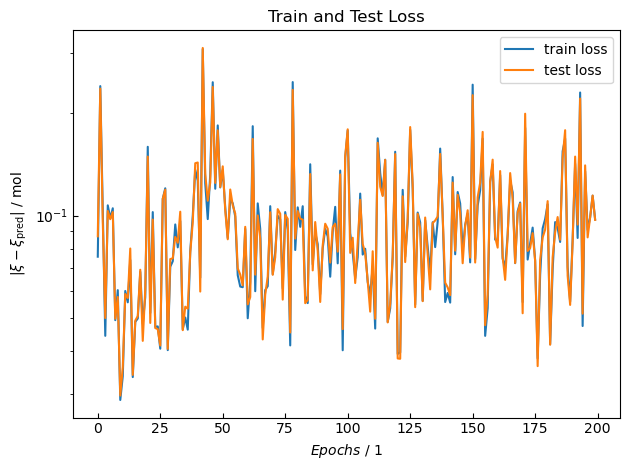

In [9]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

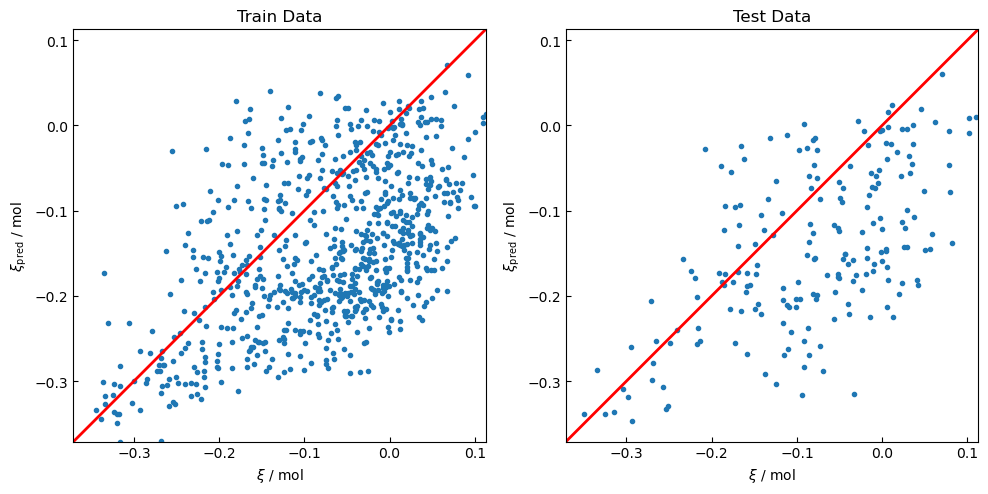

In [10]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

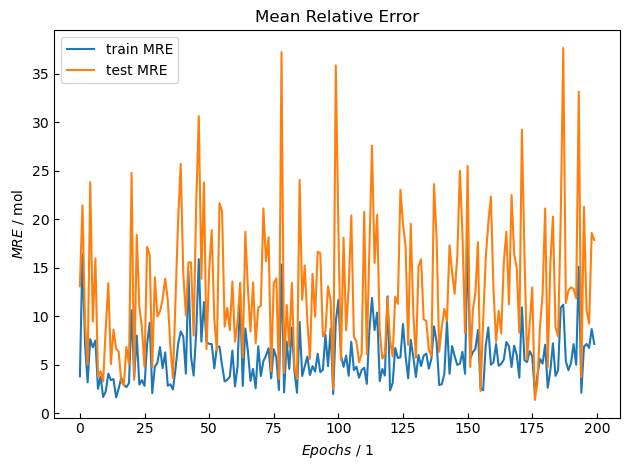

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

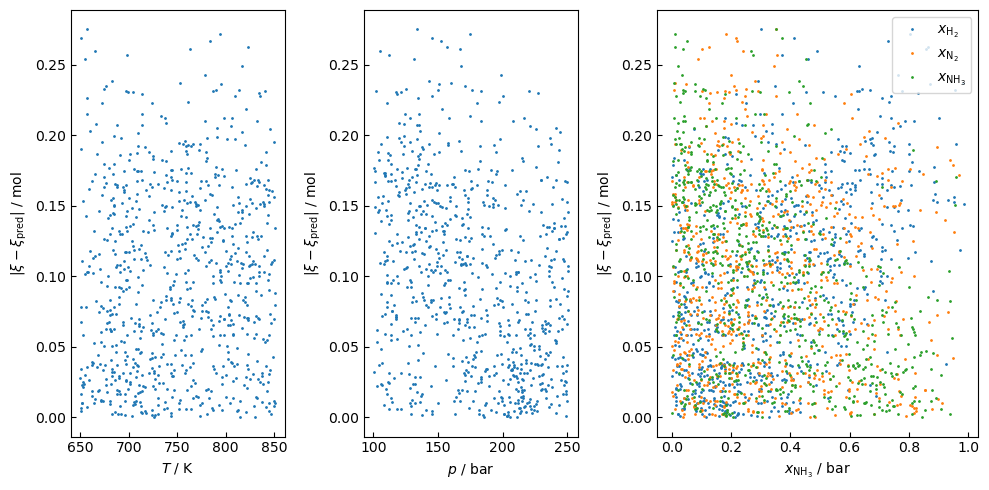

In [12]:
mistake = []
param_T = []
param_p = []
param_x_H2 = []
param_x_N2 = []
param_x_NH3 = []
for X,y in train_dataloader:
    mistake = np.append(mistake, abs(y - net(X).detach().numpy()))
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2 = np.append(param_x_H2, X[:,2])
    param_x_N2 = np.append(param_x_N2, X[:,3])
    param_x_NH3 = np.append(param_x_NH3, X[:,4])
    
# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(1,3, figsize = (10, 5), gridspec_kw={'width_ratios': [2,2,3]})

ax[0].plot(param_T, mistake, '.', markersize = 2)
ax[0].set(xlabel = '$T$ / K', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)

ax[1].plot(param_p, mistake, '.', markersize = 2)
ax[1].set(xlabel = '$p$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)

ax[2].plot(param_x_H2, mistake, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[2].plot(param_x_N2, mistake, '.', markersize = 2, label = '$x\mathregular{_{N_2}}$')
ax[2].plot(param_x_NH3, mistake, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[2].set(xlabel = '$x\mathregular{_{NH_3}}$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[2].tick_params(direction = 'in') #, length = 20, width = 3)
ax[2].set

plt.legend()
plt.tight_layout()
plt.show()

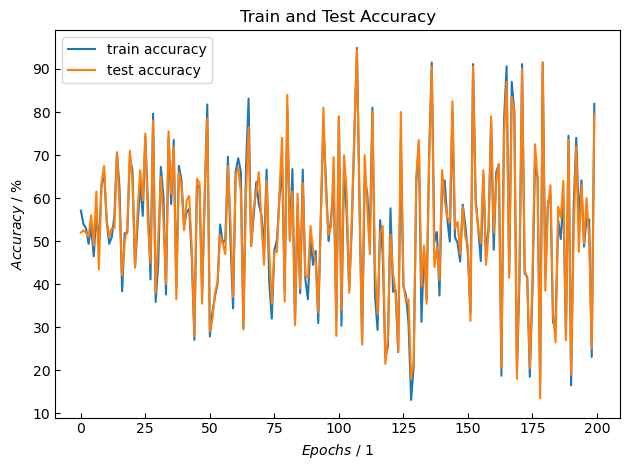

In [13]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [14]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[6.9203e+02, 1.1971e+02, 1.8870e-01, 7.2026e-01, 9.1036e-02],
        [8.1671e+02, 2.4731e+02, 1.7561e-01, 3.0300e-01, 5.2139e-01],
        [8.3198e+02, 2.2866e+02, 3.3342e-01, 2.8006e-01, 3.8651e-01],
        [7.2657e+02, 1.8313e+02, 3.7772e-01, 4.9798e-01, 1.2430e-01],
        [7.3734e+02, 2.4739e+02, 4.3876e-01, 4.4509e-01, 1.1615e-01],
        [7.2611e+02, 1.8617e+02, 5.2054e-01, 3.7025e-01, 1.0922e-01],
        [7.9258e+02, 1.8763e+02, 5.7403e-01, 3.0813e-02, 3.9516e-01],
        [7.6656e+02, 2.3153e+02, 4.4711e-01, 2.4900e-01, 3.0388e-01],
        [8.4229e+02, 2.3966e+02, 6.0574e-01, 2.2130e-01, 1.7296e-01],
        [7.5945e+02, 1.9172e+02, 4.0926e-01, 5.3635e-01, 5.4388e-02],
        [7.8947e+02, 2.1305e+02, 3.3482e-01, 4.4783e-01, 2.1735e-01],
        [7.0471e+02, 2.0407e+02, 3.7700e-02, 7.8814e-01, 1.7416e-01],
        [7.6488e+02, 2.4551e+02, 2.5730e-01, 7.1775e-01, 2.4944e-02],
        [8.0626e+02, 2.3879e+02, 2.4530e-01, 4.5124e-02, 7.0958e-01],
        [6.9715e+02,

#### Einblick in Netzwerk

In [15]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([1.3206, 1.5172, 1.1798, 1.0622, 1.1394], requires_grad=True),
 Parameter containing:
 tensor([-0.0441, -0.2204,  0.3768,  0.0879, -0.0694], requires_grad=True),
 Parameter containing:
 tensor([[ 1.8849e-02,  1.2103e+00, -4.0911e-01, -2.5980e-02,  9.8646e-02],
         [ 2.0171e-02,  1.9834e-01, -6.5332e-01, -1.3913e-01,  1.3670e+00],
         [-8.8303e-01, -5.3832e-01,  1.8011e-01,  7.6667e-01,  2.3537e-01],
         [-3.3572e-01,  8.9629e-01, -5.1137e-01,  5.2267e-01, -2.7969e-01],
         [-4.2344e-01, -1.3482e+00, -6.5538e-01,  4.4456e-01, -1.1031e-01],
         [-5.6398e-01,  2.8133e-01,  8.4173e-01, -3.0500e-01, -7.6670e-01],
         [ 4.2244e-02, -1.0188e-01,  1.3493e+00, -4.0560e-01, -8.8683e-01],
         [-1.7449e-01, -1.0120e+00, -7.4063e-01, -1.3887e-01,  5.7220e-01],
         [-6.9310e-01,  5.1275e-01, -4.2101e-01,  3.9015e-01, -4.1173e-01],
         [-2.6935e-01, -7.1705e-01, -1.0889e+00, -2.2504e-01,  3.8014e-01],
         [ 2.2990e-01, -

In [16]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.0404, 0.6415, 0.6578, 0.4525, 0.8248],
        [0.3965, 0.8028, 0.0637, 0.6058, 0.2084]])
tensor([[-0.3066],
        [-0.0423]], grad_fn=<AddmmBackward0>)


In [17]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [18]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    break

tensor([[6.7348e+02, 2.4946e+02, 3.2166e-01, 1.4695e-01, 5.3139e-01],
        [7.5222e+02, 1.1804e+02, 8.1085e-02, 1.0434e-02, 9.0848e-01],
        [7.0512e+02, 1.3186e+02, 6.4919e-01, 3.0391e-01, 4.6902e-02],
        [6.9857e+02, 1.5801e+02, 4.2545e-01, 5.0214e-01, 7.2407e-02],
        [8.4425e+02, 2.1180e+02, 4.3155e-01, 8.8767e-02, 4.7968e-01],
        [7.3221e+02, 1.6659e+02, 4.1205e-01, 3.9253e-01, 1.9542e-01],
        [6.8504e+02, 1.3679e+02, 2.2613e-01, 3.5661e-01, 4.1727e-01],
        [8.4229e+02, 2.3966e+02, 6.0574e-01, 2.2130e-01, 1.7296e-01],
        [7.7550e+02, 1.6932e+02, 1.9191e-01, 7.5363e-01, 5.4461e-02],
        [7.4477e+02, 2.2801e+02, 3.0274e-01, 1.5374e-01, 5.4352e-01],
        [7.8739e+02, 1.5809e+02, 3.0838e-01, 6.8518e-01, 6.4418e-03],
        [7.0416e+02, 1.8596e+02, 1.6179e-01, 7.6026e-01, 7.7952e-02],
        [8.0178e+02, 1.2749e+02, 2.5520e-02, 5.0545e-01, 4.6903e-01],
        [8.3936e+02, 2.2321e+02, 5.7842e-01, 3.3966e-01, 8.1922e-02],
        [8.1218e+02,